# Module 13 Problem Set Solutions
Solutions file for Module 13 Problem Set

This notebook contains the problem set for Module 13 - Dimensionality Reduction. We will be discussing more in depth **P**rinciple **C**omponent **A**nalysis (PCA), **L**inear **D**iscriminant **A**nalaysis (LDA), and **t-**distributed **S**tochastic **N**eighbor **E**mbedding (t-SNE), some common techniques for dimensionality reduction. A lot of this notebook will be talking about the "preprocessing" step for data - one of the things we'll be referencing a lot is the "feature space" of the data. **What do we mean by "feature space?"**

The *feature space* is where all our possible input features "live." Recall that our data is comprised of features - specific data points (sometimes extracted from raw data) and measurements that we pass as input to our model. The feature space the multi-dimensional area where our features lie. If we have 2 features, our feature space is a plane! If we have 3, it is a 3D area!

In mathematical terms, given inputs to our model $\mathbf{x}$ with $i$-th row $\mathbf{x_i} = [x_1, x_2, \dots, x_D]$ it is the $D$ dimensional vector space that is spanned by our features. Traditionally, we actually define the row vectors through a mapping function $\phi(x_i)$ that maps our input data to our feature space (encapsulating things like preprocessing, linear mappings, dimensionality reduction, etc.). If this type of more "lower level" math interests you, look into taking EEL5840.

## Dataset

Last week we used PCA at the beginning of our problem set - for consistency I'll be using the same dataset here 
as last week - the Breast Cancer Wisconsin dataset. For more information (details on the dataset, its source, etc.) see last week's Problem Set.

In [1]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data.data
y = data.target

**What is the native feature space of this data? You may need to print some useful variables or values in the code block.** 

In [2]:
X.shape

(569, 30)

We have 569 observations of 30 features - our feature space is $\mathbb{R}^{30}$.

## PCA

PCA is an unsupervised method for clustering data - it aims to reduce the dimensionality of the data by performing linear transformations of the input data to a target number of features. It aims to keep the variation among datapoints the same in the lower dimensional feature space. 

### PCA to a specified number of dimensions
The simplest way to use PCA is to map the input vectors to a number of features of your choosing. *Always* scale your data down before performing PCA. PCA is sensitive to the scale of data: larger variables by magnitude will have a larger effect on the model. Scaling prevents us from having *biased components*. **Scale our input data down.**

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

I want to visualize the data in 2 dimensions: let's perform PCA to map our data to 2 features, and visualize.

In [4]:
from sklearn.decomposition import PCA

n_components = 2  
pca = PCA(n_components=n_components, random_state=100)
X_pca = pca.fit_transform(X_scaled)

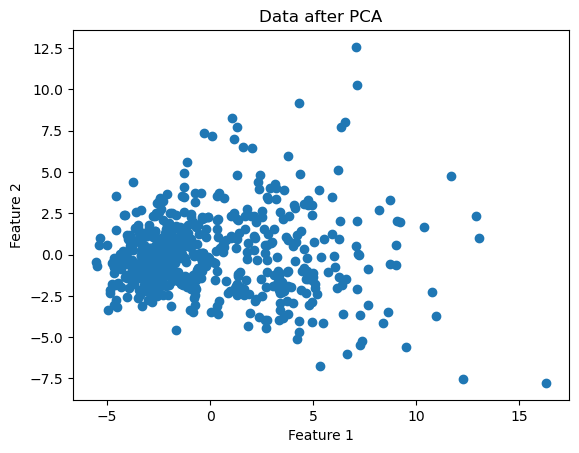

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data after PCA')
plt.show()

There are some metrics returned by our PCA that we can look at to determine how well our data is ordered: the principle one is called *explained variance ratio*, which provides a metric for analyzing how much of the variance in the data is explained by each feature. This is stored in the class variable explained_variance_ratio_ in our PCA object. **Print off this value and provide some explanation for its meaning.**

In [6]:
pca.explained_variance_ratio_

array([0.44272026, 0.18971182])

44% of the variance is explained by feature 1, and 19% by Feature 2.

### Using Probability to select the number of dimensions
Sometimes we have some prior knowledge about our data and know what feature space we want our data to be in, or want to plot our data in 2D for visualization - in these cases it makes sense for us to specify the number of dimensions. However, sometimes we don't know yet! Rather than performing a grid search for lots of different dimensions, we can leverage probability to select the best number of dimensions. 

Using a technique called Maximum Likelihood Estimation (MLE), we can estimate the dimensionality of the data by maximizing the likelihood function, which measures the probability of observing the input data under a given model. It will find the parameters that make the observed data most probable. **Fit another PCA to the data (in a different variable), this time using MLE to select the number of features. What is the dimensionality of the new feature space?**

In [7]:
pca_mle = PCA(n_components='mle', random_state=100)
X_mle = pca_mle.fit_transform(X_scaled)
print(f'MLE estimated that we have {pca_mle.n_components_} components in the data.')

MLE estimated that we have 29 components in the data.


This value means that a lot of our data is estimataed to be useful for prediction - we only removed 1 feature. Let's look at the variance ratios:

In [8]:
pca_mle.explained_variance_ratio_ * 100  # Looking at percentages

array([4.42720256e+01, 1.89711820e+01, 9.39316326e+00, 6.60213492e+00,
       5.49576849e+00, 4.02452204e+00, 2.25073371e+00, 1.58872380e+00,
       1.38964937e+00, 1.16897819e+00, 9.79718988e-01, 8.70537901e-01,
       8.04524987e-01, 5.23365745e-01, 3.13783217e-01, 2.66209337e-01,
       1.97996793e-01, 1.75395945e-01, 1.64925306e-01, 1.03864675e-01,
       9.99096464e-02, 9.14646751e-02, 8.11361259e-02, 6.01833567e-02,
       5.16042379e-02, 2.72587995e-02, 2.30015463e-02, 5.29779290e-03,
       2.49601032e-03])

Naturally, as we have more features in the data each explains less of the variance. We still have our original 2 features (44 and 19%)  and additional features in decreasing order of explained variance ratios. Note that small numbers don't mean that they're useless features! 

## LDA

### LDA as a Classifier
Originally LDA was first used as a method for classification rather than dimensionality reducion by Ronald Fisher (the person the F-statistic is named for, and the person who popularized the t-test). It's goal is to find a linear combination of features that separate the classes of the data best.

It intrinsically makes a few assumptions about the data: 
1. Each class is normally distributed in the feature space
2. All classes share the same covariance matrix

**It is a *supervised* algorithm, meaning what?**

LDA being supervised means that we require labels for our classes for the algorithm to work! 

Let's train the LDA classifier on our data. Similarly, we should use scaled data.

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_classifier = LinearDiscriminantAnalysis(solver='eigen')  # Use eigenvalues for covariance matrices to solve
lda_classifier.fit(X_scaled, y)
y_pred = lda_classifier.predict(X_scaled)

In [10]:
from sklearn.metrics import accuracy_score, f1_score

print(f'LDA achieved accuracy {round(accuracy_score(y_true=y, y_pred=y_pred)*100,2)} and'
      f' F1 Score {round(f1_score(y_true=y, y_pred=y_pred)*100, 2)}.')

LDA achieved accuracy 96.49 and F1 Score 97.26.


**Good model? Bad? Is something wrong?**

We are not performing a fair evaluation!! We are doing a supervised learning algorithm and evaluating on our training set - we should split the data into training and testing and *then* evaluate!!

**Fix the thing that's wrong.**

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=100)
lda_classifier = LinearDiscriminantAnalysis(solver='eigen')
lda_classifier.fit(X_train, y_train)

y_pred = lda_classifier.predict(X_test)

print(f'LDA achieved accuracy {round(accuracy_score(y_true=y_test, y_pred=y_pred)*100,2)} and'
      f' F1 Score {round(f1_score(y_true=y_test, y_pred=y_pred)*100, 2)}.')  

LDA achieved accuracy 95.1 and F1 Score 96.13.


### LDA for Feature Reduction
While LDA can be used as a classifier, it is more often used to reduce the dimensionality of the input data to a specific feature space. While we cannot use MLE to estimate the number of features, we can still select the number of features with some restrictions. *Critically*, LDA is restricted by the number of classes we want to predict. LDA uses the between class variance to calculate eigenvectors - which has a rank of at most the number of classes - 1. *For binary classificaiton with LDA, we cannot have any more than 1 feature.* Going back to the entire dataset here:

In [12]:
n_components = 1
lda = LinearDiscriminantAnalysis(n_components=n_components)
X_lda = lda.fit_transform(X_scaled, y)

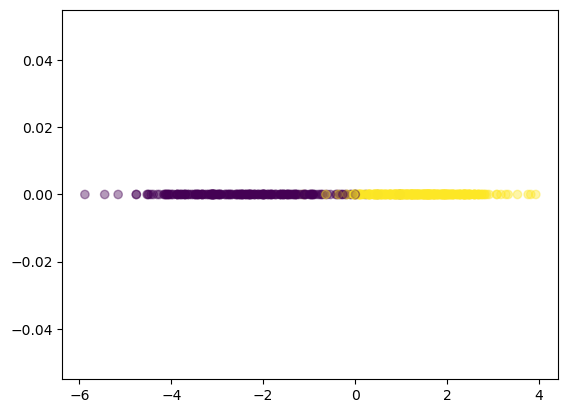

In [13]:
import numpy as np
plt.scatter(X_lda, np.zeros_like(X_lda), c=y, cmap='viridis', alpha=0.4, marker='o')
plt.show()

## t-SNE
t-SNE is a tool to reduce the dimensionaly of data that connects points through minimizing the difference in probabilities of its lower-dimensional embedding and the higher-dimensional data. It is more "probabilistic"  than LDA or PCA.

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=100)
X_tsne = tsne.fit_transform(X_scaled)

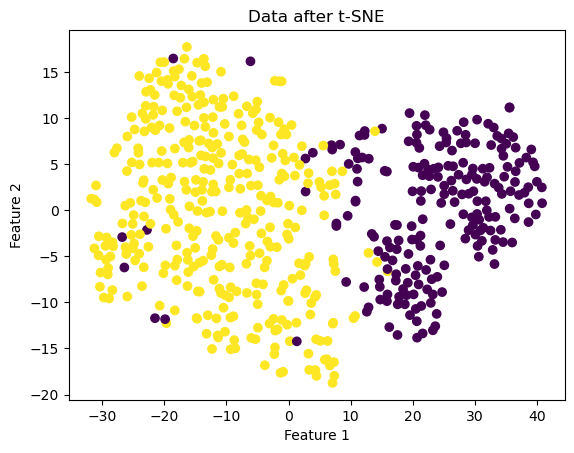

In [19]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.title('Data after t-SNE')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Comparision

### Comparison of Feature Space Projections

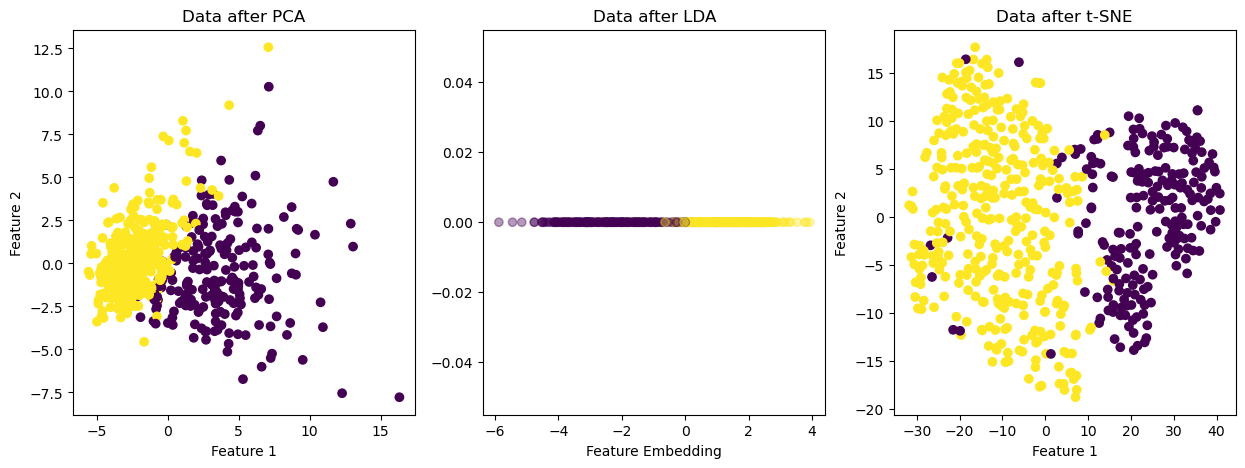

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title('Data after PCA')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(132)
plt.title('Data after LDA')
plt.scatter(X_lda[:, 0], np.zeros_like(X_lda), c=y, cmap='viridis', alpha=0.4, marker='o')
plt.xlabel('Feature Embedding')

plt.subplot(133)
plt.title('Data after t-SNE')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()